In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
import random
from models_ukb import ModelA, ModelB
from hyperparameter_options import params_baseline as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 5
multi_gpus = [5, 6]
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [11]:
# shuffle the dataset
df = df.sample(frac=1, random_state=23) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [12]:
df.groupby(["Sex"])["PTID"].count()

Sex
Female    1005
Male       849
Name: PTID, dtype: int64

In [13]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [14]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

# Define the classifier

In [15]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [16]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 22) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        no_test_df = data.sample(frac=0.8, random_state=r) # split according 
         # split train/validation
        train_df = no_test_df.sample(frac=0.8, random_state=32) # can be the same r at each inner fold
        val_df = no_test_df[~no_test_df["PTID"].isin(train_df["PTID"])]
        
        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        print(len(ukb_data_train))
        print(len(ukb_data_val))
        
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelA"
            elif inner_fold < 4:
                model_name = "ModelB"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)   
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(
                ukb_data_train, batch_size=b, shuffle=True, num_workers=4
            )

            val_loader = DataLoader(
                ukb_data_val, batch_size=2, shuffle=True, num_workers=2
            )

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=60,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models

In [17]:
num_epochs = 200
min_iters = 3
ignore_epochs = 30
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [18]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/10xrandom_splits/baseline_r2/"

In [21]:
!ls $output_dir

outer_0_inner_0_cv_fold_0_BEST_ITERATION.h5
outer_0_inner_0_cv_fold_0_training_epoch_68_FINAL.h5
outer_0_inner_1_cv_fold_1_BEST_ITERATION.h5
outer_0_inner_1_cv_fold_1_training_epoch_135_FINAL.h5
outer_0_inner_2_cv_fold_2_BEST_ITERATION.h5
outer_0_inner_2_cv_fold_2_training_epoch_110_FINAL.h5
outer_0_inner_3_cv_fold_3_BEST_ITERATION.h5
outer_0_inner_3_cv_fold_3_training_epoch_141_FINAL.h5
outer_0_inner_4_cv_fold_4_BEST_ITERATION.h5
outer_0_inner_4_cv_fold_4_training_epoch_65_FINAL.h5
outer_1_inner_0_cv_fold_5_BEST_ITERATION.h5
outer_1_inner_0_cv_fold_5_training_epoch_162_FINAL.h5
outer_1_inner_1_cv_fold_6_BEST_ITERATION.h5
outer_1_inner_1_cv_fold_6_training_epoch_66_FINAL.h5
outer_1_inner_2_cv_fold_7_BEST_ITERATION.h5
outer_1_inner_2_cv_fold_7_training_epoch_98_FINAL.h5
outer_1_inner_3_cv_fold_8_BEST_ITERATION.h5
outer_1_inner_3_cv_fold_8_training_epoch_186_FINAL.h5
outer_1_inner_4_cv_fold_9_BEST_ITERATION.h5
outer_1_inner_4_cv_fold_9_training_epoch_89_FINAL.h5


###### Starting outer fold 0
1186
297
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    60] loss: 0.69829
[0,   120] loss: 0.69763
[0,   180] loss: 0.70073
[0,   240] loss: 0.68172
Time elapsed: 0h:2m:14s
train accuracy_score: 52.45 %
train balanced_accuracy: 49.74 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688713
[1,    60] loss: 0.69525
[1,   120] loss: 0.68165
[1,   180] loss: 0.69060
[1,   240] loss: 0.70237
Time elapsed: 0h:5m:17s
train accuracy_score: 53.20 %
train balanced_accuracy: 50.10 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688314
[2,    60] loss: 0.70004
[2,   120] loss: 0.69430
[2,   180] loss: 0.68276
[2,   240] loss: 0.69659
Time elapsed: 0h:8m:17s
train accuracy_score: 54.38 %
train balanced_accuracy: 51.86 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.684559
[3,    60] loss:

[30,    60] loss: 0.32506
[30,   120] loss: 0.30732
[30,   180] loss: 0.34985
[30,   240] loss: 0.33898
Time elapsed: 1h:32m:13s
train accuracy_score: 84.74 %
train balanced_accuracy: 84.65 %
val accuracy_score: 86.20 %
val balanced_accuracy: 85.93 %
Val loss: 0.276717
[31,    60] loss: 0.34872
[31,   120] loss: 0.24591
[31,   180] loss: 0.28459
[31,   240] loss: 0.31616
Time elapsed: 1h:35m:12s
train accuracy_score: 87.10 %
train balanced_accuracy: 87.13 %
val accuracy_score: 83.50 %
val balanced_accuracy: 82.28 %
Val loss: 0.325259
[32,    60] loss: 0.30122
[32,   120] loss: 0.34048
[32,   180] loss: 0.31373
[32,   240] loss: 0.26762
Time elapsed: 1h:38m:13s
train accuracy_score: 87.44 %
train balanced_accuracy: 87.32 %
val accuracy_score: 86.53 %
val balanced_accuracy: 85.62 %
Val loss: 0.307488
[33,    60] loss: 0.32457
[33,   120] loss: 0.22387
[33,   180] loss: 0.32600
[33,   240] loss: 0.30812
Time elapsed: 1h:41m:12s
train accuracy_score: 87.10 %
train balanced_accuracy: 87.00 

Time elapsed: 3h:7m:15s
train accuracy_score: 90.81 %
train balanced_accuracy: 90.81 %
val accuracy_score: 89.23 %
val balanced_accuracy: 89.07 %
Val loss: 0.228025
[61,    60] loss: 0.22381
[61,   120] loss: 0.23209
[61,   180] loss: 0.20401
[61,   240] loss: 0.19867
Time elapsed: 3h:10m:16s
train accuracy_score: 91.40 %
train balanced_accuracy: 91.35 %
val accuracy_score: 86.53 %
val balanced_accuracy: 85.56 %
Val loss: 0.293715
[62,    60] loss: 0.22892
[62,   120] loss: 0.19254
[62,   180] loss: 0.21429
[62,   240] loss: 0.18899
Time elapsed: 3h:13m:18s
train accuracy_score: 91.15 %
train balanced_accuracy: 91.18 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.40 %
Val loss: 0.239789
[63,    60] loss: 0.17235
[63,   120] loss: 0.21761
[63,   180] loss: 0.23829
[63,   240] loss: 0.22262
Time elapsed: 3h:16m:18s
train accuracy_score: 91.15 %
train balanced_accuracy: 91.07 %
val accuracy_score: 87.21 %
val balanced_accuracy: 86.48 %
Val loss: 0.262606
[64,    60] loss: 0.19259

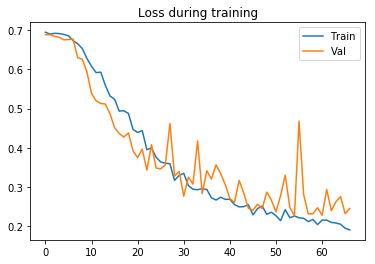

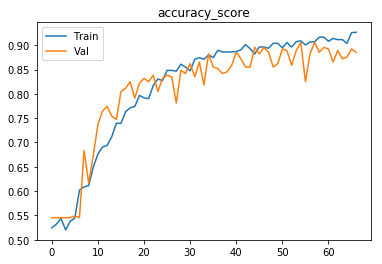

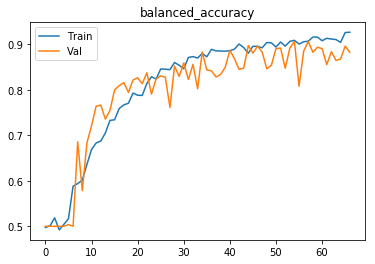

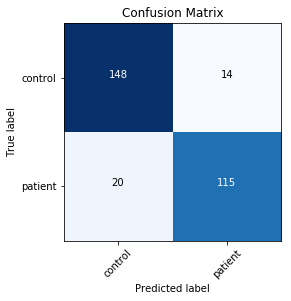

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    60] loss: 0.69664
[0,   120] loss: 0.69822
[0,   180] loss: 0.68857
Time elapsed: 0h:2m:3s
train accuracy_score: 52.95 %
train balanced_accuracy: 50.28 %
val accuracy_score: 53.87 %
val balanced_accuracy: 49.51 %
Val loss: 0.689591
[1,    60] loss: 0.68870
[1,   120] loss: 0.69672
[1,   180] loss: 0.68721
Time elapsed: 0h:5m:8s
train accuracy_score: 53.29 %
train balanced_accuracy: 50.88 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687940
[2,    60] loss: 0.69463
[2,   120] loss: 0.68974
[2,   180] loss: 0.70029
Time elapsed: 0h:8m:15s
train accuracy_score: 52.28 %
train balanced_accuracy: 48.95 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.686677
[3,    60] loss: 0.69311
[3,   120] loss: 0.69544
[3,   180] loss: 0.68896
Time elapsed: 0h:11m:19s
train accuracy_score: 52.36 %
train balanced_accura

[33,   180] loss: 0.30440
Time elapsed: 1h:47m:28s
train accuracy_score: 88.11 %
train balanced_accuracy: 88.03 %
val accuracy_score: 87.21 %
val balanced_accuracy: 86.91 %
Val loss: 0.323700
[34,    60] loss: 0.24622
[34,   120] loss: 0.25708
[34,   180] loss: 0.27598
Time elapsed: 1h:50m:44s
train accuracy_score: 89.04 %
train balanced_accuracy: 89.03 %
val accuracy_score: 88.55 %
val balanced_accuracy: 88.33 %
Val loss: 0.298993
[35,    60] loss: 0.30715
[35,   120] loss: 0.26746
[35,   180] loss: 0.28086
Time elapsed: 1h:53m:44s
train accuracy_score: 88.20 %
train balanced_accuracy: 88.08 %
val accuracy_score: 87.54 %
val balanced_accuracy: 86.91 %
Val loss: 0.329046
[36,    60] loss: 0.26244
[36,   120] loss: 0.24023
[36,   180] loss: 0.26169
Time elapsed: 1h:56m:45s
train accuracy_score: 90.22 %
train balanced_accuracy: 90.13 %
val accuracy_score: 82.83 %
val balanced_accuracy: 83.70 %
Val loss: 0.409076
[37,    60] loss: 0.24762
[37,   120] loss: 0.27095
[37,   180] loss: 0.2435

[67,    60] loss: 0.21286
[67,   120] loss: 0.21661
[67,   180] loss: 0.18954
Time elapsed: 3h:31m:30s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.72 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.09 %
Val loss: 0.333136
[68,    60] loss: 0.18614
[68,   120] loss: 0.21191
[68,   180] loss: 0.19382
Time elapsed: 3h:34m:33s
train accuracy_score: 90.73 %
train balanced_accuracy: 90.69 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.88 %
Val loss: 0.265775
[69,    60] loss: 0.15558
[69,   120] loss: 0.17370
[69,   180] loss: 0.20301
Time elapsed: 3h:37m:37s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.46 %
val accuracy_score: 90.91 %
val balanced_accuracy: 91.23 %
Val loss: 0.245657
[70,    60] loss: 0.16833
[70,   120] loss: 0.20126
[70,   180] loss: 0.19514
Time elapsed: 3h:40m:41s
train accuracy_score: 91.48 %
train balanced_accuracy: 91.49 %
val accuracy_score: 87.54 %
val balanced_accuracy: 87.16 %
Val loss: 0.317913
[71,    60] loss: 0.1924

val accuracy_score: 92.59 %
val balanced_accuracy: 92.35 %
Val loss: 0.211658
[101,    60] loss: 0.15385
[101,   120] loss: 0.17929
[101,   180] loss: 0.12330
Time elapsed: 5h:17m:52s
train accuracy_score: 93.09 %
train balanced_accuracy: 93.05 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.32 %
Val loss: 0.249388
[102,    60] loss: 0.12020
[102,   120] loss: 0.16071
[102,   180] loss: 0.13922
Time elapsed: 5h:20m:53s
train accuracy_score: 93.68 %
train balanced_accuracy: 93.64 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.48 %
Val loss: 0.250093
[103,    60] loss: 0.13864
[103,   120] loss: 0.12280
[103,   180] loss: 0.13683
Time elapsed: 5h:23m:55s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.97 %
val accuracy_score: 90.91 %
val balanced_accuracy: 91.05 %
Val loss: 0.235129
[104,    60] loss: 0.15847
[104,   120] loss: 0.18503
[104,   180] loss: 0.13661
Time elapsed: 5h:26m:57s
train accuracy_score: 93.51 %
train balanced_accuracy: 93.54 %
val accuracy

Best result during training: 0.94. Saving model..
Finished inner fold.


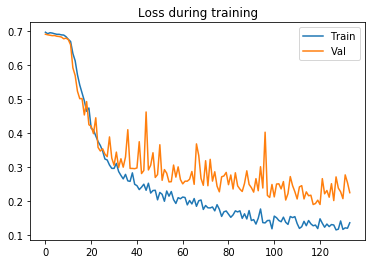

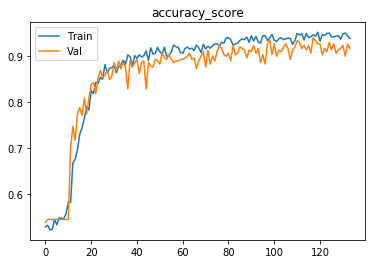

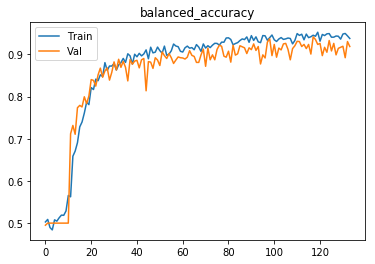

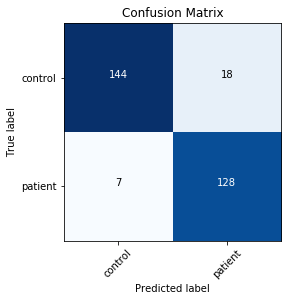

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    60] loss: 0.69570
Time elapsed: 0h:2m:2s
train accuracy_score: 52.78 %
train balanced_accuracy: 50.75 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.689540
[1,    60] loss: 0.69356
Time elapsed: 0h:5m:4s
train accuracy_score: 52.87 %
train balanced_accuracy: 50.71 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.686589
[2,    60] loss: 0.69567
Time elapsed: 0h:8m:6s
train accuracy_score: 52.95 %
train balanced_accuracy: 50.51 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687061
[3,    60] loss: 0.69472
Time elapsed: 0h:11m:3s
train accuracy_score: 51.60 %
train balanced_accuracy: 49.36 %
val accuracy_score: 55.56 %
val balanced_accuracy: 51.11 %
Val loss: 0.690707
[4,    60] loss: 0.69245
Time elapsed: 0h:14m:6s
train accuracy_score: 52.61 %
train balanced_accuracy: 49.50 %

Time elapsed: 2h:9m:17s
train accuracy_score: 89.88 %
train balanced_accuracy: 89.78 %
val accuracy_score: 85.52 %
val balanced_accuracy: 86.23 %
Val loss: 0.327215
[43,    60] loss: 0.25722
Time elapsed: 2h:12m:17s
train accuracy_score: 88.87 %
train balanced_accuracy: 88.76 %
val accuracy_score: 87.54 %
val balanced_accuracy: 88.15 %
Val loss: 0.285223
[44,    60] loss: 0.24157
Time elapsed: 2h:15m:19s
train accuracy_score: 90.22 %
train balanced_accuracy: 90.20 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.58 %
Val loss: 0.245216
[45,    60] loss: 0.24961
Time elapsed: 2h:18m:21s
train accuracy_score: 89.97 %
train balanced_accuracy: 89.87 %
val accuracy_score: 88.22 %
val balanced_accuracy: 88.46 %
Val loss: 0.244225
[46,    60] loss: 0.25885
Time elapsed: 2h:21m:16s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.28 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.57 %
Val loss: 0.243166
[47,    60] loss: 0.22151
Time elapsed: 2h:24m:17s
train accuracy_s

[85,    60] loss: 0.17448
Time elapsed: 4h:19m:31s
train accuracy_score: 93.17 %
train balanced_accuracy: 93.08 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.36 %
Val loss: 0.195082
[86,    60] loss: 0.14342
Time elapsed: 4h:22m:31s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.93 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.59 %
Val loss: 0.180829
[87,    60] loss: 0.13082
Time elapsed: 4h:25m:34s
train accuracy_score: 94.01 %
train balanced_accuracy: 93.98 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.41 %
Val loss: 0.196730
[88,    60] loss: 0.14317
Time elapsed: 4h:28m:30s
train accuracy_score: 93.34 %
train balanced_accuracy: 93.28 %
val accuracy_score: 90.91 %
val balanced_accuracy: 91.36 %
Val loss: 0.227814
[89,    60] loss: 0.19251
Time elapsed: 4h:31m:27s
train accuracy_score: 91.99 %
train balanced_accuracy: 91.95 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.21 %
Val loss: 0.175395
[90,    60] loss: 0.14853
Time elapsed: 

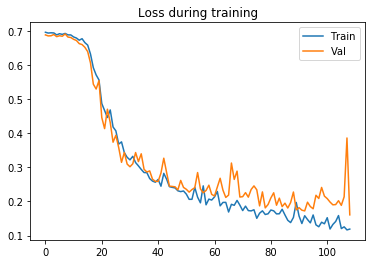

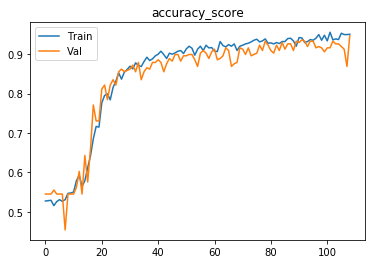

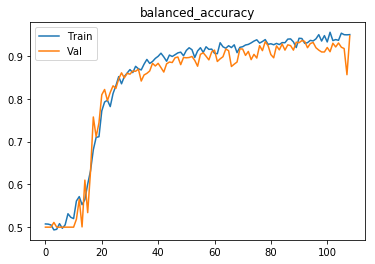

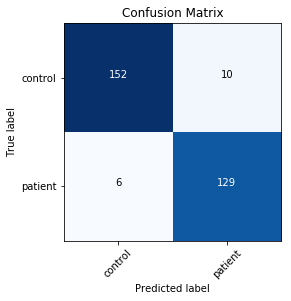

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    60] loss: 0.69871
[0,   120] loss: 0.69954
[0,   180] loss: 0.69323
Time elapsed: 0h:2m:2s
train accuracy_score: 49.92 %
train balanced_accuracy: 47.53 %
val accuracy_score: 53.87 %
val balanced_accuracy: 50.37 %
Val loss: 0.689608
[1,    60] loss: 0.70469
[1,   120] loss: 0.70000
[1,   180] loss: 0.68892
Time elapsed: 0h:5m:3s
train accuracy_score: 51.60 %
train balanced_accuracy: 49.59 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.695295
[2,    60] loss: 0.69312
[2,   120] loss: 0.69823
[2,   180] loss: 0.68854
Time elapsed: 0h:8m:2s
train accuracy_score: 52.70 %
train balanced_accuracy: 49.84 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.689550
[3,    60] loss: 0.68417
[3,   120] loss: 0.70033
[3,   180] loss: 0.68768
Time elapsed: 0h:11m:2s
train accuracy_score: 54.72 %
train balanced_accuracy:

Time elapsed: 1h:41m:25s
train accuracy_score: 86.42 %
train balanced_accuracy: 86.36 %
val accuracy_score: 86.20 %
val balanced_accuracy: 86.11 %
Val loss: 0.326951
[34,    60] loss: 0.33229
[34,   120] loss: 0.32216
[34,   180] loss: 0.22914
Time elapsed: 1h:44m:24s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.54 %
val accuracy_score: 87.54 %
val balanced_accuracy: 87.65 %
Val loss: 0.302014
[35,    60] loss: 0.33498
[35,   120] loss: 0.26116
[35,   180] loss: 0.39693
Time elapsed: 1h:47m:23s
train accuracy_score: 87.27 %
train balanced_accuracy: 87.22 %
val accuracy_score: 85.52 %
val balanced_accuracy: 85.00 %
Val loss: 0.313730
[36,    60] loss: 0.31792
[36,   120] loss: 0.30303
[36,   180] loss: 0.30617
Time elapsed: 1h:50m:21s
train accuracy_score: 87.69 %
train balanced_accuracy: 87.64 %
val accuracy_score: 86.20 %
val balanced_accuracy: 86.11 %
Val loss: 0.307381
[37,    60] loss: 0.30951
[37,   120] loss: 0.29548
[37,   180] loss: 0.27744
Time elapsed: 1h:53m:19s

[67,    60] loss: 0.17554
[67,   120] loss: 0.18014
[67,   180] loss: 0.19236
Time elapsed: 3h:23m:45s
train accuracy_score: 93.76 %
train balanced_accuracy: 93.77 %
val accuracy_score: 87.88 %
val balanced_accuracy: 86.98 %
Val loss: 0.291680
[68,    60] loss: 0.17262
[68,   120] loss: 0.20041
[68,   180] loss: 0.20426
Time elapsed: 3h:26m:48s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.40 %
val accuracy_score: 89.23 %
val balanced_accuracy: 89.01 %
Val loss: 0.238424
[69,    60] loss: 0.15879
[69,   120] loss: 0.19504
[69,   180] loss: 0.15506
Time elapsed: 3h:29m:51s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.40 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.69 %
Val loss: 0.213592
[70,    60] loss: 0.16625
[70,   120] loss: 0.19495
[70,   180] loss: 0.16506
Time elapsed: 3h:32m:52s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.40 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.43 %
Val loss: 0.226976
[71,    60] loss: 0.1313

val accuracy_score: 90.57 %
val balanced_accuracy: 90.12 %
Val loss: 0.199658
[101,    60] loss: 0.15308
[101,   120] loss: 0.14188
[101,   180] loss: 0.14371
Time elapsed: 5h:6m:31s
train accuracy_score: 93.59 %
train balanced_accuracy: 93.54 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.20 %
Val loss: 0.238326
[102,    60] loss: 0.19919
[102,   120] loss: 0.14859
[102,   180] loss: 0.14461
Time elapsed: 5h:9m:30s
train accuracy_score: 93.00 %
train balanced_accuracy: 93.02 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.85 %
Val loss: 0.182200
[103,    60] loss: 0.10818
[103,   120] loss: 0.15012
[103,   180] loss: 0.14181
Time elapsed: 5h:12m:32s
train accuracy_score: 94.01 %
train balanced_accuracy: 94.01 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.91 %
Val loss: 0.184935
[104,    60] loss: 0.11255
[104,   120] loss: 0.14269
[104,   180] loss: 0.09958
Time elapsed: 5h:15m:34s
train accuracy_score: 95.95 %
train balanced_accuracy: 96.00 %
val accuracy_s

[134,    60] loss: 0.12948
[134,   120] loss: 0.16088
[134,   180] loss: 0.08919
Time elapsed: 6h:45m:34s
train accuracy_score: 94.27 %
train balanced_accuracy: 94.30 %
val accuracy_score: 90.24 %
val balanced_accuracy: 89.44 %
Val loss: 0.238150
[135,    60] loss: 0.09422
[135,   120] loss: 0.08788
[135,   180] loss: 0.12859
Time elapsed: 6h:48m:34s
train accuracy_score: 95.87 %
train balanced_accuracy: 95.90 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.02 %
Val loss: 0.171358
[136,    60] loss: 0.11115
[136,   120] loss: 0.13121
[136,   180] loss: 0.09306
Time elapsed: 6h:51m:37s
train accuracy_score: 95.19 %
train balanced_accuracy: 95.27 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.15 %
Val loss: 0.170388
[137,    60] loss: 0.10090
[137,   120] loss: 0.09656
[137,   180] loss: 0.09505
Time elapsed: 6h:54m:38s
train accuracy_score: 95.28 %
train balanced_accuracy: 95.30 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.30 %
Val loss: 0.206913
[138,    60]

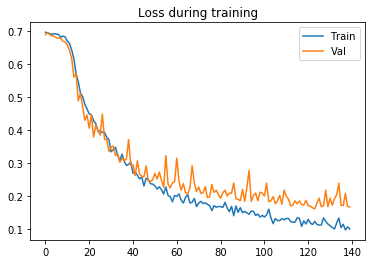

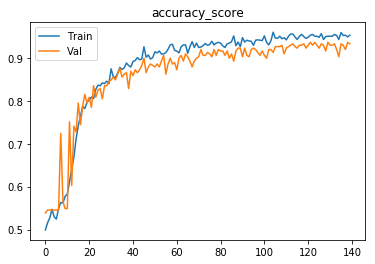

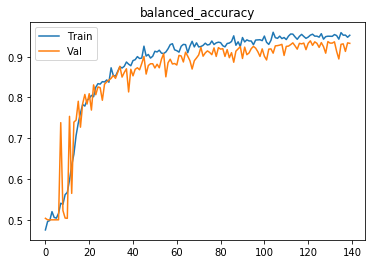

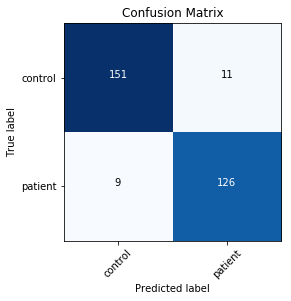

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    60] loss: 0.69242
[0,   120] loss: 0.70055
[0,   180] loss: 0.69550
[0,   240] loss: 0.69814
Time elapsed: 0h:2m:0s
train accuracy_score: 51.18 %
train balanced_accuracy: 48.46 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.692028
[1,    60] loss: 0.70455
[1,   120] loss: 0.69131
[1,   180] loss: 0.69083
[1,   240] loss: 0.69139
Time elapsed: 0h:4m:57s
train accuracy_score: 53.20 %
train balanced_accuracy: 49.50 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.686525
[2,    60] loss: 0.69182
[2,   120] loss: 0.69413
[2,   180] loss: 0.69596
[2,   240] loss: 0.68915
Time elapsed: 0h:7m:54s
train accuracy_score: 53.54 %
train balanced_accuracy: 49.71 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687069
[3,    60] loss: 0.69906
[3,   120] loss: 0.69015
[3,   180] loss: 0.68812
[

[30,   120] loss: 0.22425
[30,   180] loss: 0.38631
[30,   240] loss: 0.24000
Time elapsed: 1h:31m:21s
train accuracy_score: 87.69 %
train balanced_accuracy: 87.50 %
val accuracy_score: 84.85 %
val balanced_accuracy: 85.68 %
Val loss: 0.368329
[31,    60] loss: 0.27222
[31,   120] loss: 0.25081
[31,   180] loss: 0.30368
[31,   240] loss: 0.25383
Time elapsed: 1h:34m:19s
train accuracy_score: 90.05 %
train balanced_accuracy: 89.96 %
val accuracy_score: 87.21 %
val balanced_accuracy: 87.04 %
Val loss: 0.256107
[32,    60] loss: 0.28417
[32,   120] loss: 0.28881
[32,   180] loss: 0.24899
[32,   240] loss: 0.29893
Time elapsed: 1h:37m:18s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.14 %
val accuracy_score: 86.20 %
val balanced_accuracy: 85.56 %
Val loss: 0.291880
[33,    60] loss: 0.29299
[33,   120] loss: 0.21566
[33,   180] loss: 0.30890
[33,   240] loss: 0.24734
Time elapsed: 1h:40m:15s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.08 %
val accuracy_score: 86.2

val accuracy_score: 88.55 %
val balanced_accuracy: 87.96 %
Val loss: 0.233830
[61,    60] loss: 0.17127
[61,   120] loss: 0.21292
[61,   180] loss: 0.19685
[61,   240] loss: 0.14957
Time elapsed: 3h:1m:41s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.67 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.38 %
Val loss: 0.218937
[62,    60] loss: 0.16776
[62,   120] loss: 0.16489
[62,   180] loss: 0.27273
[62,   240] loss: 0.18685
Time elapsed: 3h:4m:38s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.71 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.33 %
Val loss: 0.224498
[63,    60] loss: 0.17131
[63,   120] loss: 0.22986
[63,   180] loss: 0.20635
[63,   240] loss: 0.20409
Time elapsed: 3h:7m:33s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.34 %
val accuracy_score: 90.57 %
val balanced_accuracy: 90.49 %
Val loss: 0.204776
Early stopping in epoch 64
Total time elapsed: 3h:8m:31s
Writing model to disk...
Best result during training: 0.91

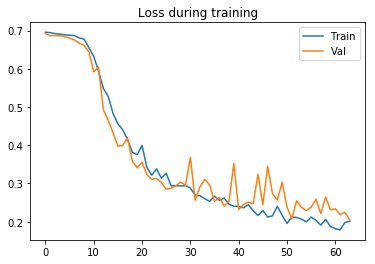

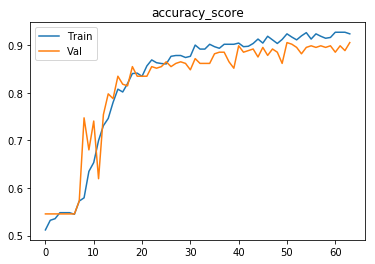

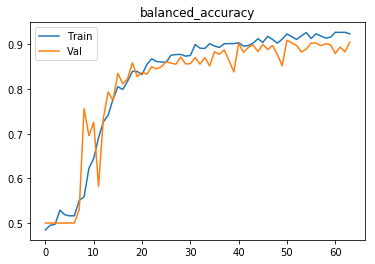

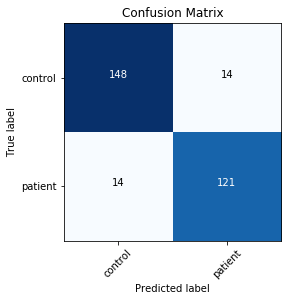

Finished outer fold.
{'final_acc': 0.932716049382716, 'best_acc': 0.938888888888889, 'final_iter': 140, 'best_iter': 122, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 1
1186
297
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    60] loss: 0.69569
Time elapsed: 0h:2m:7s
train accuracy_score: 49.24 %
train balanced_accuracy: 49.13 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.690873
[1,    60] loss: 0.69272
Time elapsed: 0h:5m:8s
train accuracy_score: 52.87 %
train balanced_accuracy: 51.48 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.691288
[2,    60] loss: 0.69135
Time elapsed: 0h:8m:9s
train accuracy_score: 51.60 %
train balanced_accuracy: 50.68 %
val accuracy_score: 44.44 %
val balanced_accuracy: 50.00 %
Val loss: 0.693131
[3,    60] loss: 0.6966

[41,    60] loss: 0.26238
Time elapsed: 2h:4m:11s
train accuracy_score: 89.04 %
train balanced_accuracy: 89.07 %
val accuracy_score: 86.87 %
val balanced_accuracy: 86.36 %
Val loss: 0.279907
[42,    60] loss: 0.30550
Time elapsed: 2h:7m:11s
train accuracy_score: 87.52 %
train balanced_accuracy: 87.58 %
val accuracy_score: 85.86 %
val balanced_accuracy: 85.08 %
Val loss: 0.298710
[43,    60] loss: 0.29515
Time elapsed: 2h:10m:9s
train accuracy_score: 88.53 %
train balanced_accuracy: 88.48 %
val accuracy_score: 87.54 %
val balanced_accuracy: 88.41 %
Val loss: 0.312411
[44,    60] loss: 0.28850
Time elapsed: 2h:13m:6s
train accuracy_score: 88.20 %
train balanced_accuracy: 88.18 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.61 %
Val loss: 0.272991
[45,    60] loss: 0.28195
Time elapsed: 2h:16m:5s
train accuracy_score: 88.62 %
train balanced_accuracy: 88.65 %
val accuracy_score: 89.56 %
val balanced_accuracy: 90.15 %
Val loss: 0.288127
[46,    60] loss: 0.25131
Time elapsed: 2h:19

[84,    60] loss: 0.17987
Time elapsed: 4h:12m:3s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.86 %
val accuracy_score: 88.22 %
val balanced_accuracy: 89.24 %
Val loss: 0.263445
[85,    60] loss: 0.15417
Time elapsed: 4h:15m:2s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.49 %
val accuracy_score: 91.58 %
val balanced_accuracy: 92.05 %
Val loss: 0.215266
[86,    60] loss: 0.15487
Time elapsed: 4h:18m:1s
train accuracy_score: 93.00 %
train balanced_accuracy: 93.06 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.32 %
Val loss: 0.182601
[87,    60] loss: 0.16547
Time elapsed: 4h:20m:58s
train accuracy_score: 92.58 %
train balanced_accuracy: 92.59 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.05 %
Val loss: 0.197938
[88,    60] loss: 0.17077
Time elapsed: 4h:23m:54s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.79 %
val accuracy_score: 93.94 %
val balanced_accuracy: 93.94 %
Val loss: 0.188097
[89,    60] loss: 0.14966
Time elapsed: 4h:

val accuracy_score: 93.27 %
val balanced_accuracy: 93.11 %
Val loss: 0.169114
[127,    60] loss: 0.14041
Time elapsed: 6h:20m:16s
train accuracy_score: 94.18 %
train balanced_accuracy: 94.23 %
val accuracy_score: 91.25 %
val balanced_accuracy: 90.38 %
Val loss: 0.218472
[128,    60] loss: 0.10177
Time elapsed: 6h:23m:13s
train accuracy_score: 95.78 %
train balanced_accuracy: 95.82 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.48 %
Val loss: 0.168520
[129,    60] loss: 0.10541
Time elapsed: 6h:26m:10s
train accuracy_score: 95.62 %
train balanced_accuracy: 95.68 %
val accuracy_score: 94.61 %
val balanced_accuracy: 94.70 %
Val loss: 0.154908
[130,    60] loss: 0.13805
Time elapsed: 6h:29m:12s
train accuracy_score: 94.77 %
train balanced_accuracy: 94.80 %
val accuracy_score: 93.94 %
val balanced_accuracy: 94.02 %
Val loss: 0.158096
[131,    60] loss: 0.12885
Time elapsed: 6h:32m:13s
train accuracy_score: 94.86 %
train balanced_accuracy: 94.89 %
val accuracy_score: 93.27 %
val bal

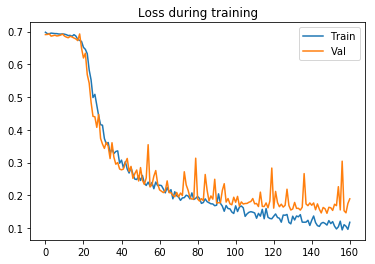

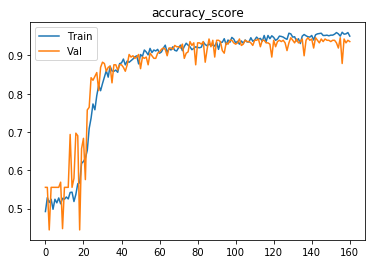

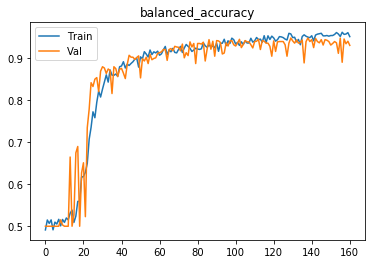

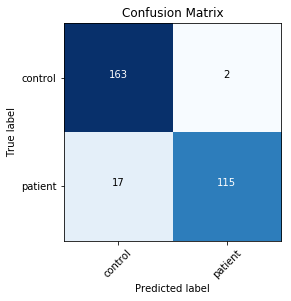

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    60] loss: 0.69708
Time elapsed: 0h:1m:57s
train accuracy_score: 50.34 %
train balanced_accuracy: 49.44 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.686937
[1,    60] loss: 0.70030
Time elapsed: 0h:4m:57s
train accuracy_score: 50.84 %
train balanced_accuracy: 50.10 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.683730
[2,    60] loss: 0.69201
Time elapsed: 0h:7m:52s
train accuracy_score: 51.85 %
train balanced_accuracy: 50.76 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.689385
[3,    60] loss: 0.69025
Time elapsed: 0h:10m:48s
train accuracy_score: 52.36 %
train balanced_accuracy: 51.51 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.683853
[4,    60] loss: 0.69349
Time elapsed: 0h:13m:44s
train accuracy_score: 51.69 %
train balanced_accuracy: 5

Time elapsed: 2h:6m:3s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.73 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.67 %
Val loss: 0.237148
[43,    60] loss: 0.26696
Time elapsed: 2h:9m:3s
train accuracy_score: 88.87 %
train balanced_accuracy: 88.85 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.56 %
Val loss: 0.261258
[44,    60] loss: 0.32594
Time elapsed: 2h:12m:1s
train accuracy_score: 87.52 %
train balanced_accuracy: 87.51 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.44 %
Val loss: 0.217730
[45,    60] loss: 0.23997
Time elapsed: 2h:14m:59s
train accuracy_score: 90.73 %
train balanced_accuracy: 90.70 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.27 %
Val loss: 0.203070
[46,    60] loss: 0.31067
Time elapsed: 2h:17m:56s
train accuracy_score: 87.94 %
train balanced_accuracy: 87.88 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.36 %
Val loss: 0.206948
[47,    60] loss: 0.22023
Time elapsed: 2h:20m:54s
train accuracy_score

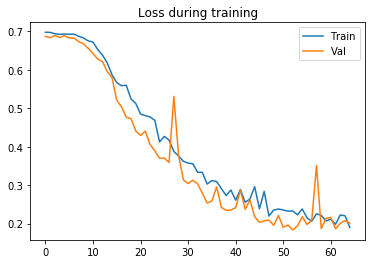

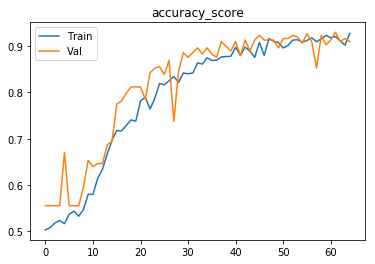

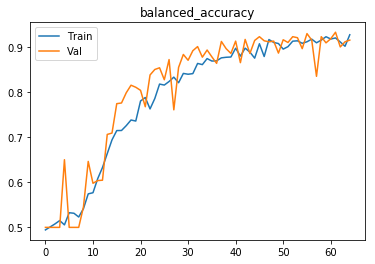

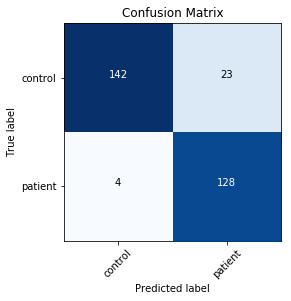

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    60] loss: 0.70949
[0,   120] loss: 0.67923
[0,   180] loss: 0.70351
Time elapsed: 0h:1m:57s
train accuracy_score: 50.67 %
train balanced_accuracy: 50.11 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.685840
[1,    60] loss: 0.69262
[1,   120] loss: 0.69887
[1,   180] loss: 0.69966
Time elapsed: 0h:4m:53s
train accuracy_score: 50.51 %
train balanced_accuracy: 49.83 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.684976
[2,    60] loss: 0.70168
[2,   120] loss: 0.69465
[2,   180] loss: 0.69331
Time elapsed: 0h:7m:48s
train accuracy_score: 51.26 %
train balanced_accuracy: 50.49 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.686678
[3,    60] loss: 0.69714
[3,   120] loss: 0.69646
[3,   180] loss: 0.69410
Time elapsed: 0h:10m:42s
train accuracy_score: 49.33 %
train balanced_accu

[33,   180] loss: 0.35275
Time elapsed: 1h:38m:56s
train accuracy_score: 87.61 %
train balanced_accuracy: 87.61 %
val accuracy_score: 86.20 %
val balanced_accuracy: 85.61 %
Val loss: 0.284447
[34,    60] loss: 0.28976
[34,   120] loss: 0.27265
[34,   180] loss: 0.23537
Time elapsed: 1h:41m:58s
train accuracy_score: 88.95 %
train balanced_accuracy: 88.93 %
val accuracy_score: 87.54 %
val balanced_accuracy: 87.05 %
Val loss: 0.275419
[35,    60] loss: 0.25887
[35,   120] loss: 0.29734
[35,   180] loss: 0.29504
Time elapsed: 1h:45m:0s
train accuracy_score: 88.87 %
train balanced_accuracy: 88.85 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.70 %
Val loss: 0.246306
[36,    60] loss: 0.25622
[36,   120] loss: 0.23209
[36,   180] loss: 0.25876
Time elapsed: 1h:48m:6s
train accuracy_score: 88.87 %
train balanced_accuracy: 88.88 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.23 %
Val loss: 0.239959
[37,    60] loss: 0.27196
[37,   120] loss: 0.22804
[37,   180] loss: 0.25218


[67,    60] loss: 0.13486
[67,   120] loss: 0.14811
[67,   180] loss: 0.18999
Time elapsed: 3h:22m:4s
train accuracy_score: 93.00 %
train balanced_accuracy: 93.00 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.41 %
Val loss: 0.173743
[68,    60] loss: 0.19179
[68,   120] loss: 0.18415
[68,   180] loss: 0.14504
Time elapsed: 3h:25m:8s
train accuracy_score: 93.25 %
train balanced_accuracy: 93.26 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.35 %
Val loss: 0.210803
[69,    60] loss: 0.17073
[69,   120] loss: 0.12979
[69,   180] loss: 0.12956
Time elapsed: 3h:28m:11s
train accuracy_score: 94.10 %
train balanced_accuracy: 94.13 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.33 %
Val loss: 0.181460
[70,    60] loss: 0.14318
[70,   120] loss: 0.18302
[70,   180] loss: 0.13211
Time elapsed: 3h:31m:15s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.43 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.42 %
Val loss: 0.195332
[71,    60] loss: 0.14481


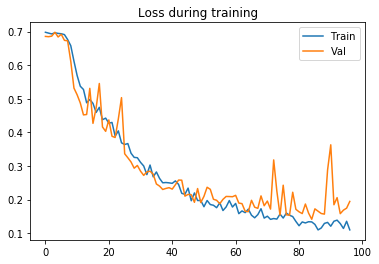

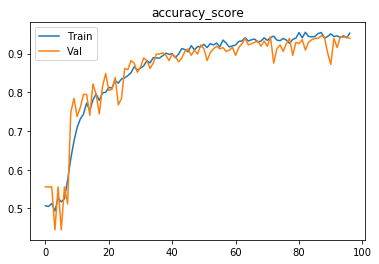

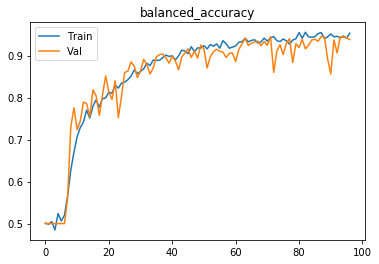

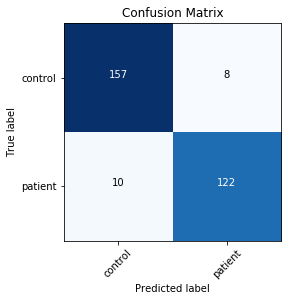

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    60] loss: 0.69842
[0,   120] loss: 0.70163
[0,   180] loss: 0.69507
[0,   240] loss: 0.68773
Time elapsed: 0h:2m:1s
train accuracy_score: 48.48 %
train balanced_accuracy: 47.32 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.690340
[1,    60] loss: 0.70024
[1,   120] loss: 0.69875
[1,   180] loss: 0.69285
[1,   240] loss: 0.68769
Time elapsed: 0h:5m:1s
train accuracy_score: 50.08 %
train balanced_accuracy: 49.03 %
val accuracy_score: 44.44 %
val balanced_accuracy: 50.00 %
Val loss: 0.698554
[2,    60] loss: 0.69500
[2,   120] loss: 0.69005
[2,   180] loss: 0.68411
[2,   240] loss: 0.70034
Time elapsed: 0h:7m:59s
train accuracy_score: 52.61 %
train balanced_accuracy: 51.64 %
val accuracy_score: 44.44 %
val balanced_accuracy: 50.00 %
Val loss: 0.693034
[3,    60] loss: 0.69109
[3,   120] loss: 0.69730
[3,   180] loss: 0.69525
[3

[30,   120] loss: 0.20489
[30,   180] loss: 0.41902
[30,   240] loss: 0.27380
Time elapsed: 1h:31m:53s
train accuracy_score: 88.03 %
train balanced_accuracy: 87.99 %
val accuracy_score: 88.55 %
val balanced_accuracy: 87.95 %
Val loss: 0.235399
[31,    60] loss: 0.28101
[31,   120] loss: 0.26480
[31,   180] loss: 0.23222
[31,   240] loss: 0.28324
Time elapsed: 1h:34m:51s
train accuracy_score: 89.46 %
train balanced_accuracy: 89.43 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.70 %
Val loss: 0.238459
[32,    60] loss: 0.21423
[32,   120] loss: 0.31159
[32,   180] loss: 0.31298
[32,   240] loss: 0.26720
Time elapsed: 1h:37m:52s
train accuracy_score: 88.36 %
train balanced_accuracy: 88.34 %
val accuracy_score: 86.87 %
val balanced_accuracy: 85.68 %
Val loss: 0.249216
[33,    60] loss: 0.31442
[33,   120] loss: 0.25554
[33,   180] loss: 0.25810
[33,   240] loss: 0.29421
Time elapsed: 1h:40m:51s
train accuracy_score: 89.12 %
train balanced_accuracy: 89.13 %
val accuracy_score: 88.8

val accuracy_score: 91.25 %
val balanced_accuracy: 91.21 %
Val loss: 0.189721
[61,    60] loss: 0.15131
[61,   120] loss: 0.21200
[61,   180] loss: 0.23222
[61,   240] loss: 0.23221
Time elapsed: 3h:4m:11s
train accuracy_score: 90.64 %
train balanced_accuracy: 90.67 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.52 %
Val loss: 0.184909
[62,    60] loss: 0.23812
[62,   120] loss: 0.19308
[62,   180] loss: 0.22614
[62,   240] loss: 0.17563
Time elapsed: 3h:7m:11s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.10 %
val accuracy_score: 92.59 %
val balanced_accuracy: 93.26 %
Val loss: 0.231700
[63,    60] loss: 0.24662
[63,   120] loss: 0.27164
[63,   180] loss: 0.25543
[63,   240] loss: 0.16681
Time elapsed: 3h:10m:10s
train accuracy_score: 89.29 %
train balanced_accuracy: 89.26 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.59 %
Val loss: 0.181684
[64,    60] loss: 0.20470
[64,   120] loss: 0.18879
[64,   180] loss: 0.20125
[64,   240] loss: 0.22212
Time elaps

[91,   180] loss: 0.15602
[91,   240] loss: 0.16146
Time elapsed: 4h:33m:39s
train accuracy_score: 92.66 %
train balanced_accuracy: 92.65 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.12 %
Val loss: 0.177974
[92,    60] loss: 0.11473
[92,   120] loss: 0.24039
[92,   180] loss: 0.18223
[92,   240] loss: 0.18076
Time elapsed: 4h:36m:38s
train accuracy_score: 92.92 %
train balanced_accuracy: 92.93 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.79 %
Val loss: 0.169237
[93,    60] loss: 0.14154
[93,   120] loss: 0.17805
[93,   180] loss: 0.15401
[93,   240] loss: 0.18456
Time elapsed: 4h:39m:37s
train accuracy_score: 94.01 %
train balanced_accuracy: 94.04 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.64 %
Val loss: 0.168739
[94,    60] loss: 0.23534
[94,   120] loss: 0.11540
[94,   180] loss: 0.14085
[94,   240] loss: 0.15623
Time elapsed: 4h:42m:36s
train accuracy_score: 94.01 %
train balanced_accuracy: 94.02 %
val accuracy_score: 90.91 %
val balanced_accuracy:

[121,   240] loss: 0.14475
Time elapsed: 6h:4m:16s
train accuracy_score: 94.35 %
train balanced_accuracy: 94.38 %
val accuracy_score: 94.61 %
val balanced_accuracy: 94.92 %
Val loss: 0.141178
[122,    60] loss: 0.13507
[122,   120] loss: 0.13018
[122,   180] loss: 0.14857
[122,   240] loss: 0.14449
Time elapsed: 6h:7m:20s
train accuracy_score: 94.35 %
train balanced_accuracy: 94.36 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.88 %
Val loss: 0.146386
[123,    60] loss: 0.08051
[123,   120] loss: 0.13846
[123,   180] loss: 0.14145
[123,   240] loss: 0.12430
Time elapsed: 6h:10m:24s
train accuracy_score: 94.52 %
train balanced_accuracy: 94.54 %
val accuracy_score: 89.90 %
val balanced_accuracy: 88.79 %
Val loss: 0.218308
[124,    60] loss: 0.13388
[124,   120] loss: 0.13184
[124,   180] loss: 0.15985
[124,   240] loss: 0.13822
Time elapsed: 6h:13m:27s
train accuracy_score: 94.44 %
train balanced_accuracy: 94.45 %
val accuracy_score: 93.94 %
val balanced_accuracy: 94.39 %
Val lo

[151,   240] loss: 0.13324
Time elapsed: 7h:35m:48s
train accuracy_score: 94.10 %
train balanced_accuracy: 94.10 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.52 %
Val loss: 0.150367
[152,    60] loss: 0.09670
[152,   120] loss: 0.10239
[152,   180] loss: 0.13709
[152,   240] loss: 0.12939
Time elapsed: 7h:38m:50s
train accuracy_score: 94.52 %
train balanced_accuracy: 94.54 %
val accuracy_score: 94.95 %
val balanced_accuracy: 94.70 %
Val loss: 0.117491
[153,    60] loss: 0.09696
[153,   120] loss: 0.08254
[153,   180] loss: 0.09041
[153,   240] loss: 0.09842
Time elapsed: 7h:41m:52s
train accuracy_score: 95.62 %
train balanced_accuracy: 95.63 %
val accuracy_score: 95.29 %
val balanced_accuracy: 95.00 %
Val loss: 0.120325
[154,    60] loss: 0.09493
[154,   120] loss: 0.10627
[154,   180] loss: 0.11210
[154,   240] loss: 0.10811
Time elapsed: 7h:44m:55s
train accuracy_score: 96.21 %
train balanced_accuracy: 96.21 %
val accuracy_score: 94.95 %
val balanced_accuracy: 95.08 %
Val 

[181,   240] loss: 0.09558
Time elapsed: 9h:7m:25s
train accuracy_score: 95.95 %
train balanced_accuracy: 95.97 %
val accuracy_score: 94.95 %
val balanced_accuracy: 95.00 %
Val loss: 0.116743
[182,    60] loss: 0.05928
[182,   120] loss: 0.10164
[182,   180] loss: 0.09303
[182,   240] loss: 0.08120
Time elapsed: 9h:10m:27s
train accuracy_score: 96.04 %
train balanced_accuracy: 96.06 %
val accuracy_score: 91.58 %
val balanced_accuracy: 92.35 %
Val loss: 0.210465
[183,    60] loss: 0.06328
[183,   120] loss: 0.08903
[183,   180] loss: 0.12027
[183,   240] loss: 0.10840
Time elapsed: 9h:13m:31s
train accuracy_score: 95.28 %
train balanced_accuracy: 95.30 %
val accuracy_score: 95.29 %
val balanced_accuracy: 95.68 %
Val loss: 0.143236
[184,    60] loss: 0.08158
[184,   120] loss: 0.08337
[184,   180] loss: 0.07393
[184,   240] loss: 0.11464
Time elapsed: 9h:16m:33s
train accuracy_score: 96.80 %
train balanced_accuracy: 96.80 %
val accuracy_score: 94.95 %
val balanced_accuracy: 94.62 %
Val l

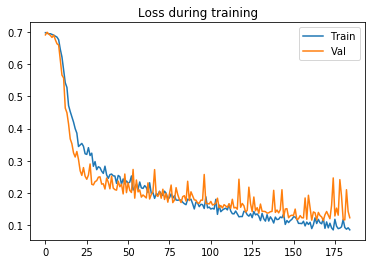

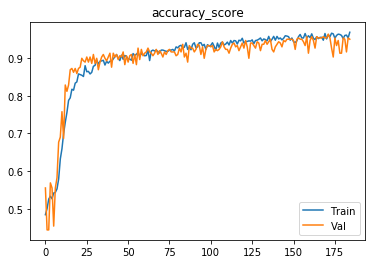

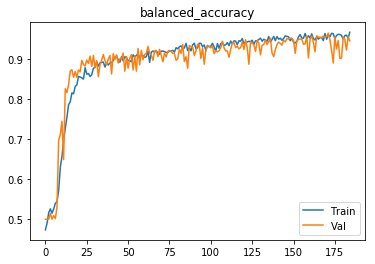

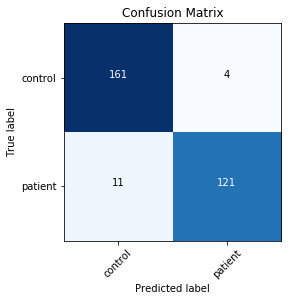

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    60] loss: 0.69555
[0,   120] loss: 0.69935
[0,   180] loss: 0.69697
Time elapsed: 0h:2m:3s
train accuracy_score: 50.34 %
train balanced_accuracy: 49.52 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.690201
[1,    60] loss: 0.69274
[1,   120] loss: 0.69617
[1,   180] loss: 0.69593
Time elapsed: 0h:5m:5s
train accuracy_score: 50.51 %
train balanced_accuracy: 49.78 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.691578
[2,    60] loss: 0.69716
[2,   120] loss: 0.69440
[2,   180] loss: 0.69358
Time elapsed: 0h:8m:8s
train accuracy_score: 50.67 %
train balanced_accuracy: 49.66 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.686411
[3,    60] loss: 0.70039
[3,   120] loss: 0.69136
[3,   180] loss: 0.69597
Time elapsed: 0h:11m:15s
train accuracy_score: 49.92 %
train balanced_accurac

In [ ]:
fold_metric, models = run(net=None, data=df,
                  k_folds=-1,
                  callbacks=None,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [ ]:
5/0

In [24]:
training_res = [{'final_acc': 0.932716049382716, 'best_acc': 0.938888888888889, 'final_iter': 140, 'best_iter': 122, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3},
{'final_acc': 0.9462, 'best_acc': 0.97, 'final_iter': 184, 'best_iter': 171, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3}]

# Start inference

In [25]:
from collections import OrderedDict

In [26]:
metrics = []

random_states = np.arange(20, 22) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    # load data
    # separate new test set each run
    no_test_df = df.sample(frac=0.8, random_state=r) # split according 
    test_df = df[~df["PTID"].isin(no_test_df["PTID"])]

    if zero_one_normalize:
        intensity = IntensityRescale()
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
    else:
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
    test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
    )
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Bal Acc"])*100, np.std(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["ROC AUC"])*100, np.std(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Sensitivity"])*100, np.std(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Specificity"])*100, np.std(metrics_df["Specificity"])*100))

Outer fold 0
Bal. accuracy 93.733 %
ROC AUC Score 98.963 %
Sensitivity 96.512 %
Specificity 90.955 %
Outer fold 1
Bal. accuracy 93.549 %
ROC AUC Score 98.666 %
Sensitivity 96.732 %
Specificity 90.367 %
######## Final results ########
    Bal Acc   ROC AUC  Sensitivity  Specificity
0  0.937332  0.989628     0.965116     0.909548
1  0.935495  0.986658     0.967320     0.903670
Balanced accuracy mean 93.641 % (0.09)
ROC AUC mean 98.814 % (0.15)
Sensitivity mean 96.622 % (0.11)
Specificity mean 90.661 % (0.29)
